In [ ]:
## Data Initializing

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/mkub/Meruza_ubuntu/GitHub/TransportNet/Stable Dynamic & Beckman/model.py'>

In [2]:
import numba
numba.__version__

'0.49.0'

# Beckmann model

parameter $\mu = 0.25$

In [2]:
beckmann_save = 'beckmann_results/'

In [3]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Frank-Wolfe algorithm

In [4]:
assert(model.mu == 0.25)
max_iter = 10000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter' : max_iter, 'eps_abs' : - np.inf,
                 'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

#with open(beckmann_save + 'anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
#    pickle.dump(result, f)

Frank-Wolfe without stopping criteria
Oracles created...
Frank-Wolfe algorithm...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.536758
Duality_gap / Duality_gap_init = 1.1198e-05

Iterations number: 4000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.292535
Duality_gap / Duality_gap_init = 6.10295e-06

Iterations number: 6000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.197301
Duality_gap / Duality_gap_init = 4.11616e-06

Iterations number: 8000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.198391
Duality_gap / Duality_gap_init = 4.13888e-06

Iterations number: 10000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.0629881
Duality_gap / Duality_gap_init = 1.31408e-06
iterations number exceeded total iters: 10000
Primal_func_v

__Checking the result with the answer from https://github.com/bstabler/TransportationNetworks__ 

In [4]:
with open(beckmann_save + 'anaheim_result_fwa_max_iter_10000_beckmann.pickle', 'rb') as f:
    result = pickle.load(f)

In [5]:
answer = handler.ReadAnswer('Anaheim_flow.tntp')
delta = abs(answer['flows'] - result['flows'])
print('Flows:')
print('total_od_flow =', total_od_flow)
print(np.min(delta))
print(np.max(delta))
print(np.linalg.norm(result['flows'] - answer['flows'], ord = 1) / np.linalg.norm(answer['flows'], ord = 1))
print(np.linalg.norm(delta) / total_od_flow)
print('Times:')
delta = abs(answer['times'] - result['times'])
print(np.min(delta))
print(np.max(delta))
print(np.sum(delta))

Flows:
total_od_flow = 104694.4
0.0
0.6930271191049542
1.5773880137928968e-05
2.9255749207286742e-05
Times:
0.0
3.994954466657319e-05
0.000398954511505345


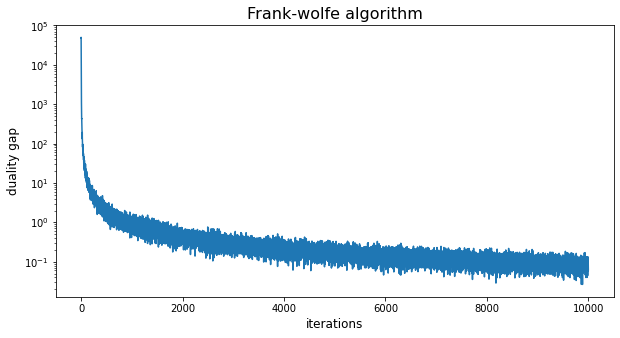

In [25]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters, dual_gaps)
plt.title('Frank-wolfe algorithm', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()

In [5]:
epsilons = np.logspace(3,-1,9)
epsilons

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01])

## Universal Similar Triangles

In [8]:
assert(model.mu == 0.25)
max_iter = 10000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter,
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'ustf' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 1000.0
Oracles created...
Universal similar triangles function...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 12
Primal_func_value = 1.28631e+06
Duality_gap / Duality_gap_init = 0.0161829
Phi_big_oracle elapsed time: 3 sec
Elapsed time: 3 sec
Time ratio = 3.0464158854257204
Flow excess = 1.1585339704654087

eps_abs = 316.22776601683796
Oracles created...
Universal similar triangles function...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 20
Primal_func_value = 1.28611e+06
Duality_gap / Duality_gap_init = 0.00610586
Phi_big_oracle elapsed time: 6 sec
Elapsed time: 6 sec
Time ratio = 3.1357283581860327
Flow excess = 1.0581530776113386

eps_abs = 100.0
Oracles created...
Universal similar triangles function...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 53
Primal_func_value = 1.28606e+06
Duality_gap / Duality_gap_init

TypeError: _from_meminfo_ptr() missing 1 required positional argument: 'listtype'

## Universal Gradient Descent

In [6]:
#weighted t added
assert(model.mu == 0.25)
max_iter = 20000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter,
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    #with open(beckmann_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
    #    pickle.dump(result, f)

eps_abs = 1000.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 106
Primal_func_value = 1.28665e+06
Duality_gap / Duality_gap_init = 0.0207516
Phi_big_oracle elapsed time: 38 sec
Elapsed time: 38 sec
Time ratio = 2.8361253585326818
Flow excess = 1.140836177474403

eps_abs = 316.22776601683796
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 978
Primal_func_value = 1.28626e+06
Duality_gap / Duality_gap_init = 0.00658936
Phi_big_oracle elapsed time: 308 sec
Elapsed time: 310 sec
Time ratio = 3.098012429880743
Flow excess = 1.050183366157893

eps_abs = 100.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4


KeyboardInterrupt: 

In [10]:
#not weighted t added, then
assert(model.mu == 0.25)
max_iter = 20000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter,
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 1000.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 66
Primal_func_value = 1.28692e+06
Duality_gap / Duality_gap_init = 0.0206516
Phi_big_oracle elapsed time: 25 sec
Elapsed time: 25 sec
Time ratio = 3.18992877650872
Flow excess = 1.1945330188679257

eps_abs = 316.22776601683796
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
success
Total iters: 810
Primal_func_value = 1.28631e+06
Duality_gap / Duality_gap_init = 0.00651527
Phi_big_oracle elapsed time: 260 sec
Elapsed time: 262 sec
Time ratio = 3.3027110804430913
Flow excess = 1.0637143799472422

eps_abs = 100.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Inner iterations number: 4019
Primal_func_value = 1.28636e+06
Dual_func_value = -1.286

eps_abs = 1.0
Oracles created...
Universal gradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Inner iterations number: 4025
Primal_func_value = 1.28987e+06
Dual_func_value = -1.28497e+06
Duality_gap = 4899.54
Duality_gap / Duality_gap_init = 0.102216

Iterations number: 4000
Inner iterations number: 8024
Primal_func_value = 1.28954e+06
Dual_func_value = -1.28515e+06
Duality_gap = 4391.62
Duality_gap / Duality_gap_init = 0.0916193

Iterations number: 6000
Inner iterations number: 12025
Primal_func_value = 1.28928e+06
Dual_func_value = -1.2853e+06
Duality_gap = 3983.92
Duality_gap / Duality_gap_init = 0.0831137

Iterations number: 8000
Inner iterations number: 16025
Primal_func_value = 1.28905e+06
Dual_func_value = -1.28542e+06
Duality_gap = 3635.76
Duality_gap / Duality_gap_init = 0.0758502

Iterations number: 10000
Inner iterations number: 20025
Primal_func_value = 1.28885e+06
Dual_func_value = -1.28551e+06
Duality

## Subgradient Descent (composite)

In [6]:
# t_weighted here
assert(model.mu == 0.25)
max_iter = 30000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter,
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs)
    toc = time.time()
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    #with open(beckmann_save + 'anaheim_result_' + 'sd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
    #    pickle.dump(result, f)

eps_abs = 1000.0
Oracles created...
Subgradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Primal_func_value = 1.28717e+06
Dual_func_value = -1.27912e+06
Duality_gap = 8049.73
Duality_gap / Duality_gap_init = 0.167936


KeyboardInterrupt: 

In [ ]:
assert(model.mu == 0.25)
max_iter = 30000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter,
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs)
    toc = time.time()
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open(beckmann_save + 'anaheim_result_' + 'sd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 1000.0
Oracles created...
Subgradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Primal_func_value = 1.28717e+06
Dual_func_value = -1.27912e+06
Duality_gap = 3918.66
Duality_gap / Duality_gap_init = 0.0817523

Iterations number: 4000
Primal_func_value = 1.28676e+06
Dual_func_value = -1.28244e+06
Duality_gap = 1683.17
Duality_gap / Duality_gap_init = 0.0351147
success
Total iters: 5810
Primal_func_value = 1.28662e+06
Duality_gap / Duality_gap_init = 0.0208486
Phi_big_oracle elapsed time: 1022 sec
Elapsed time: 1029 sec
Time ratio = 1.9743780814464997
Flow excess = 1.3123998297354684

eps_abs = 316.22776601683796
Oracles created...
Subgradient descent...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Primal_func_value = 1.28846e+06
Dual_func_value = -1.27135e+06
Duality_gap = 11289.4
Duality_gap / Duality_gap_init = 0.235522


## Subgradient Descent (non-composite)

### experiments for Beckman model ends here.

### For Stable Dynamic the cell below:

In [3]:
handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_data['graph_table']['capacity'] = graph_data['graph_table']['capacity'] # * 2.5

model = md.Model(graph_data, graph_correspondences, 
                 total_od_flow, mu = 0, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Experiment relative error vs gamma

### flow_star calculation for 2.5x capacity:

In [4]:
flows = []
times = []
iter_nums = []
primal_vals = []
dual_vals = []
dual_gaps = []

In [5]:
np.logspace(1,3,5)

array([  10.        ,   31.6227766 ,  100.        ,  316.22776602,
       1000.        ])

In [6]:
max_iter = 1000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    break
    #with open('anaheim_result_' + 'ustf' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
    #          '_2.5xCapacity.pickle', 'wb') as f:
    #    pickle.dump(result, f)

eps_abs = 10.0
Oracles created...
Universal similar triangles function...
Primal_init = 1.24813e+06
Dual_init = -1.24846e+06
Duality_gap_init = -334.271

Iterations number: 1
Inner iterations number: 1
Primal_func_value = 1.24813e+06
Dual_func_value = -1.24846e+06
Duality_gap = -334.271
Duality_gap / Duality_gap_init = 1

Iterations number: 100
Inner iterations number: 272
Primal_func_value = 1.43765e+06
Dual_func_value = -4.6598e+08
Duality_gap = -4.64542e+08
Duality_gap / Duality_gap_init = 1.38972e+06

Iterations number: 200
Inner iterations number: 570
Primal_func_value = 1.45434e+06
Dual_func_value = -1.33103e+10
Duality_gap = -1.33089e+10
Duality_gap / Duality_gap_init = 3.98146e+07

Iterations number: 300
Inner iterations number: 862
Primal_func_value = 1.56335e+06
Dual_func_value = -6.17603e+10
Duality_gap = -6.17588e+10
Duality_gap / Duality_gap_init = 1.84757e+08

Iterations number: 400
Inner iterations number: 1166
Primal_func_value = 1.62811e+06
Dual_func_value = -2.77547e+

TypeError: _from_meminfo_ptr() missing 1 required positional argument: 'listtype'

In [12]:
with open('anaheim_result_ustf_eps_abs_1_max_iter_10000_3xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

In [10]:
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'ugd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2809 sec
Time ratio = 1.6824643373488442
Flow excess = 0.019437826330495733

eps_abs = 31.622776601683793
Elapsed time: 2803 sec
Time ratio = 1.850633096695186
Flow excess = 0.009022138773227217

eps_abs = 100.0
Elapsed time: 2835 sec
Time ratio = 1.8507696151732687
Flow excess = 0.002693016123122227

eps_abs = 316.22776601683796
Elapsed time: 2904 sec
Time ratio = 1.8490051269530985
Flow excess = 0.001136132806513146

eps_abs = 1000.0
Elapsed time: 2821 sec
Time ratio = 1.846173095703354
Flow excess = 0.0003165824612991752



In [69]:
model.mu = 0
max_iter = 10000
for i, eps_abs in enumerate(np.logspace(1,3,5)):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = False)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    with open('anaheim_result_' + 'sd' + '_#' + str(i) + '_max_iter_' + str(max_iter) + 
              '_2.5xCapacity.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 10.0
Elapsed time: 2860 sec
Time ratio = 1.6817912686360952
Flow excess = 0.022141660871784596

eps_abs = 31.622776601683793
Elapsed time: 2914 sec
Time ratio = 1.8506276564255122
Flow excess = 0.008236101571247323

eps_abs = 100.0
Elapsed time: 2993 sec
Time ratio = 1.8508507197659547
Flow excess = 0.0032011040126380674

eps_abs = 316.22776601683796
Elapsed time: 2881 sec
Time ratio = 1.849675447809613
Flow excess = 0.0009314130825985867

eps_abs = 1000.0
Elapsed time: 2893 sec
Time ratio = 1.842598989878519
Flow excess = 0.0003777599694165801



###  flow star calculated and saved above

In [ ]:
model.mu = 0.25
solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 10,
                 'max_iter': 500}

tic = time.time()
result = model.find_equilibrium(solver_name = 'sd', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

In [7]:
print(np.max(times[-1] / graph_data['graph_table']['Free Flow Time']))
print(np.max(flows[-1] / graph_data['graph_table']['Capacity']) - 1)

2.8045636761264485
0.023055659918054694


In [8]:
with open('anaheim_result_ustf_eps_abs_10_max_iter_10000_2xCapacity.pickle', 'wb') as f:
    pickle.dump(result, f)

### Results in another Notebook

In [22]:
model.mu = 0

solver_kwargs = {'eps': 1e-2,
                 'eps_abs': 5,
                 'max_iter': 1000}

tic = time.time()
result = model.find_equilibrium(solver_name = 'ustf', solver_kwargs = solver_kwargs, verbose = True)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
flows.append(result['flows'])
times.append(result['times'])
iter_nums.append(result['iter_num'])
primal_vals.append(result['primal_func_history'])
dual_vals.append(result['dual_func_history'])

Oracles created...
Universal similar triangles function...
Primal_init = 1.17521e+06
Dual_init = -1.17025e+06
Duality_gap_init = 4964.56

Iterations number: 1
Inner iterations number: 1
Primal_func_value = 1.17521e+06
Dual_func_value = -1.17025e+06
Duality_gap = 4964.56
Duality_gap / Duality_gap_init = 1

Iterations number: 100
Inner iterations number: 2
Primal_func_value = 1.1737e+06
Dual_func_value = -1.1736e+06
Duality_gap = 105.992
Duality_gap / Duality_gap_init = 0.0213497

Iterations number: 200
Inner iterations number: 1
Primal_func_value = 1.1737e+06
Dual_func_value = -1.17363e+06
Duality_gap = 69.6016
Duality_gap / Duality_gap_init = 0.0140197

Iterations number: 300
Inner iterations number: 1
Primal_func_value = 1.17369e+06
Dual_func_value = -1.17364e+06
Duality_gap = 51.3706
Duality_gap / Duality_gap_init = 0.0103475

Iterations number: 400
Inner iterations number: 2
Primal_func_value = 1.17368e+06
Dual_func_value = -1.17364e+06
Duality_gap = 34.2027
Duality_gap / Duality_ga

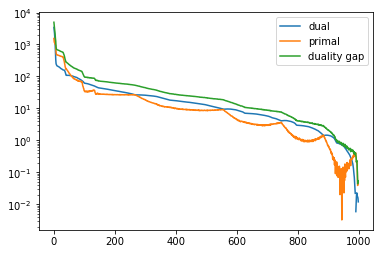

In [25]:
plt.plot(np.arange(len(dual_vals[-1])), dual_vals[-1] - np.min(dual_vals[-1]), label='dual')
plt.plot(np.arange(len(primal_vals[-1])), primal_vals[-1] - np.min(primal_vals[-1]), label='primal')
plt.plot(np.arange(len(result['duality_gap_history'])), 
         result['duality_gap_history'] - np.min(result['duality_gap_history']), 
         label='duality gap')

plt.legend()
plt.yscale('log')
plt.show()

### end for stable dynamic